<a href="https://colab.research.google.com/github/connected-bsamadi/colab-notebooks/blob/master/Stack_Overflow_Views_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow Views - Neural Network

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from google.cloud import bigquery

project_id = 'ontario-2018'
client = bigquery.Client(project=project_id)

## Ingest

In [0]:
# Number of people
n=10000

In [0]:
query = ('''
WITH
  g AS (
  SELECT
    author.name AS name,
    COUNT(commit) AS num_commits,
    COUNT(DISTINCT repo_name) AS num_repos,
    AVG(LENGTH(subject)) AS avg_subject_len,
    AVG(LENGTH(message)) AS avg_message_len,
    AVG(author.time_sec) AS avg_time,
    COALESCE(STDDEV(author.time_sec),
      0) AS std_time
  FROM
    `bigquery-public-data.github_repos.sample_commits`
  GROUP BY
    author.name),
  s AS (
  SELECT
    display_name,
    AVG(reputation) AS reputation,
    AVG(up_votes) AS up_votes,
    AVG(down_votes) AS down_votes,
    AVG(views) AS views
  FROM
    `bigquery-public-data.stackoverflow.users`
  GROUP BY
    display_name )
SELECT
  name,
  num_commits,
  num_repos,
  avg_subject_len,
  avg_message_len,
  avg_time,
  std_time,
  reputation,
  up_votes,
  down_votes,
  views
FROM
  g
INNER JOIN
  s
ON
  g.name=s.display_name
LIMIT 
'''+str(n))
job_config = bigquery.job.QueryJobConfig()
query_job = client.query(query,job_config)

In [0]:
df = query_job.to_dataframe()
df.head()

,name,num_commits,num_repos,avg_subject_len,avg_message_len,avg_time,std_time,reputation,up_votes,down_votes,views
0,Matthew Leffler,1,1,4.0,4.0,1.376438e+09,0.0,602.500000,913.500000,1.000000,62.000000
1,Nathan Howell,1,1,8.0,9.0,1.451933e+09,0.0,1348.333333,20.333333,2.333333,135.000000
2,Tushar,1,1,8.0,8.0,1.450034e+09,0.0,317.835913,13.597523,26.065015,57.678019
3,naoyashiga,1,1,8.0,9.0,1.457097e+09,0.0,8.000000,0.000000,0.000000,26.000000
4,Steve Moser,1,1,9.0,9.0,1.449166e+09,0.0,4081.000000,1373.000000,6.000000,600.000000


## Validate

In [0]:
df.isnull().sum()

name               0
num_commits        0
num_repos          0
avg_subject_len    0
avg_message_len    0
avg_time           0
std_time           0
reputation         0
up_votes           0
down_votes         0
views              0
dtype: int64

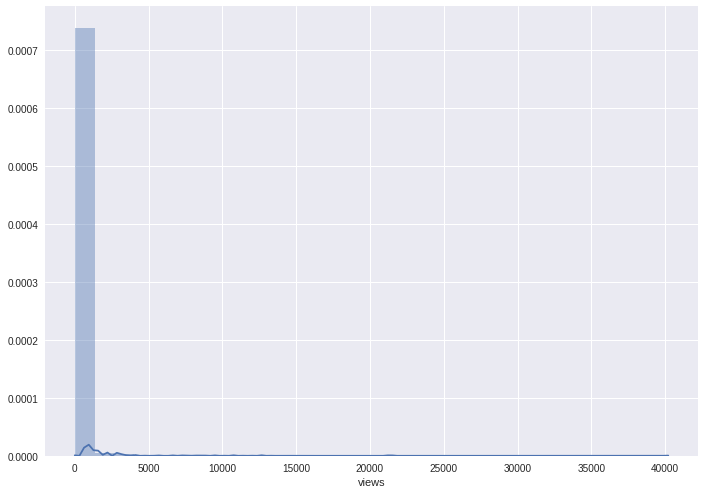

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['views'], bins=30)
plt.show()

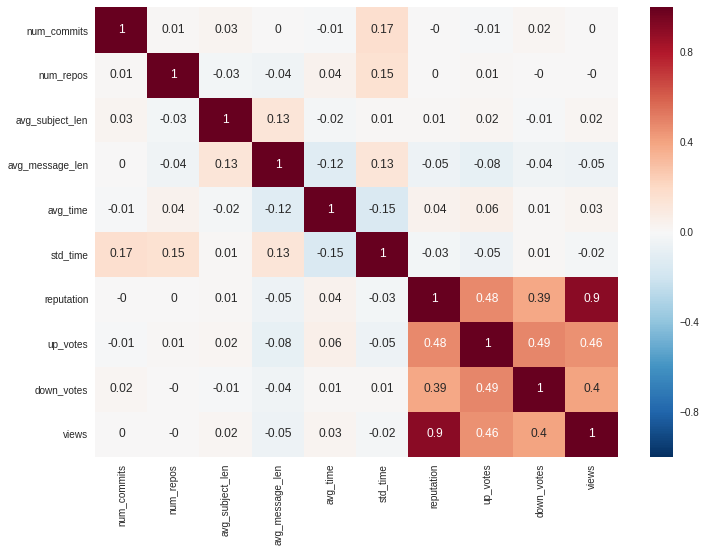

In [0]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [0]:
df.views.max()

40207.0

In [0]:
df.views.min()

0.0

In [0]:
df.views.mean()

88.89520194488

## Transform

In [0]:
rand_select = np.random.rand(len(df)) < 0.75
train_data=df[rand_select]
train_data.__delitem__('name')
train_labels=train_data.views
train_data.__delitem__('views')
test_data=df[~rand_select]
test_data.__delitem__('name')
test_labels=test_data.views
test_data.__delitem__('views')

In [0]:
# Size of the training data
train_data.shape[0]

3893

In [0]:
# Size of the testing data
test_data.shape[0]

1295

### Normalize features

In [0]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [0]:
train_labels.min()

0.0

In [0]:
train_labels.max()

12696.0

In [0]:
test_labels.min()

0.0

In [0]:
test_labels.max()

40207.0

## Build Model

In [0]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.0001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## Train

In [0]:
%%time
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 10000

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Evaluate

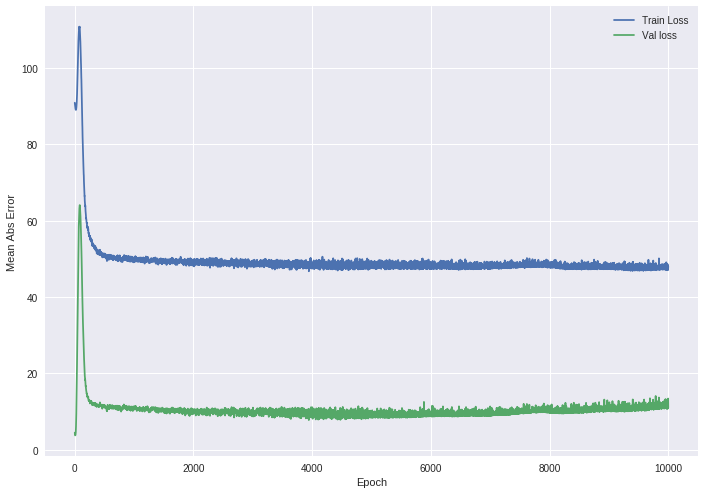

In [0]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
plot_history(history)

## Validate

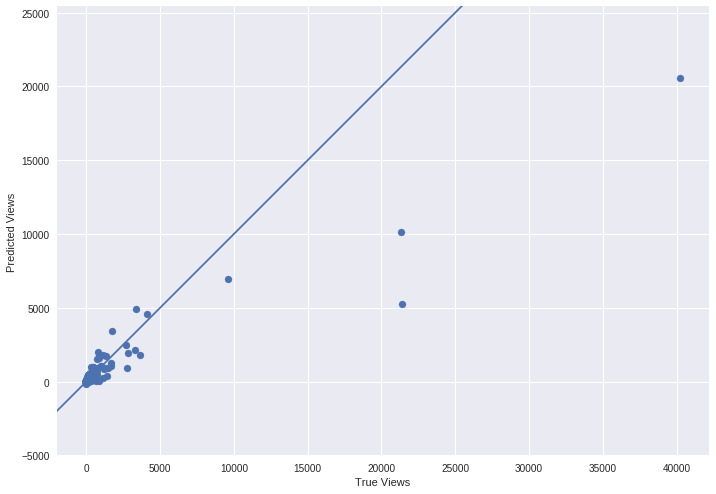

In [0]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Views')
plt.ylabel('Predicted Views')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-10000, 250000], [-10000, 250000])

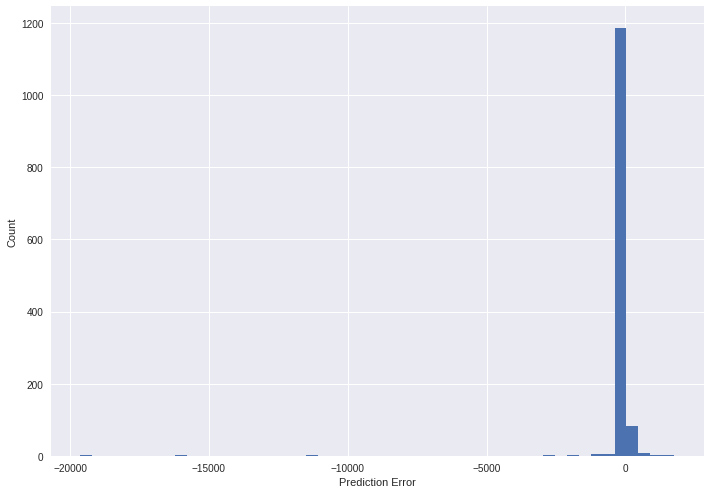

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

## Push

## Serve